In [1]:
!pip3 install vnstock
from vnstock import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import date
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

import warnings

warnings.filterwarnings('ignore')

In [3]:
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")


In [4]:
VND = VND[['Close']]
VND

,Close
Time,
2017-06-02,3280
2017-06-05,3280
2017-06-06,3320
2017-06-07,3590
2017-06-08,3540
...,...
2023-12-11,21950
2023-12-12,22050
2023-12-13,21600


In [5]:
VND['Target'] = VND.Close.shift(-1)
VND.dropna(inplace = True)
VND.head()

,Close,Target
Time,,
2017-06-02,3280,3280.0
2017-06-05,3280,3320.0
2017-06-06,3320,3590.0
2017-06-07,3590,3540.0
2017-06-08,3540,3560.0


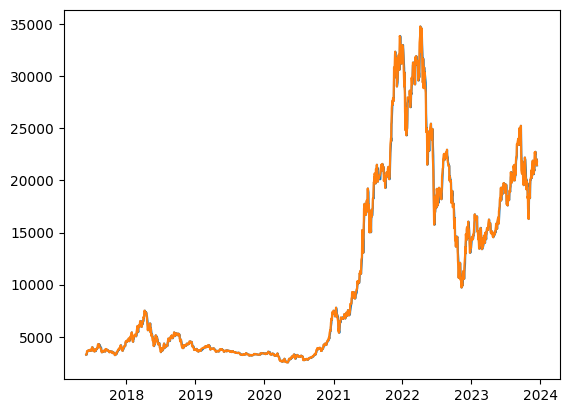

In [6]:
X = VND[['Close']]
y = VND[['Target']]

plt.plot(X)
plt.plot(y)
plt.show()

In [7]:
# chia train, test
train_size = int(0.8 * len(VND))
test_size = len(VND) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [8]:
# Define the parameter grid
# Define a dictionary 'params' where keys are hyperparameters of the XGBoost model,
# and values are lists of possible values for each hyperparameter
params = {
    'max_depth': [3, 7],
    'learning_rate': [0.05, 0.2],
    'n_estimators': [700, 1000],
    'colsample_bytree': [0.5,1]
}

# Create an XGBRegressor instance
xgbr = XGBRegressor()

# Create a GridSearchCV instance
model = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error',
    verbose=1
)

model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)
print("Lowest RMSE:", (-model.best_score_)**(1/2.0))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 700}
Lowest RMSE: 3279.060356766522


In [9]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=700,colsample_bytree=0.5, learning_rate=0.2, max_depth=7)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1,1)
print(len(y_pred))
print(len(y_test))

326
326


In [11]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
msle = mean_squared_log_error(y_test, y_pred)

print("MAPE:", mape)
print("MAE: ",  mae)
print("RMSE:", rmse)
print("MSLE: ", msle)

MAPE: 3.2189932849879117
MAE:  536.8483632093559
RMSE: Target    672.887979
dtype: float64
MSLE:  0.001633283957736816


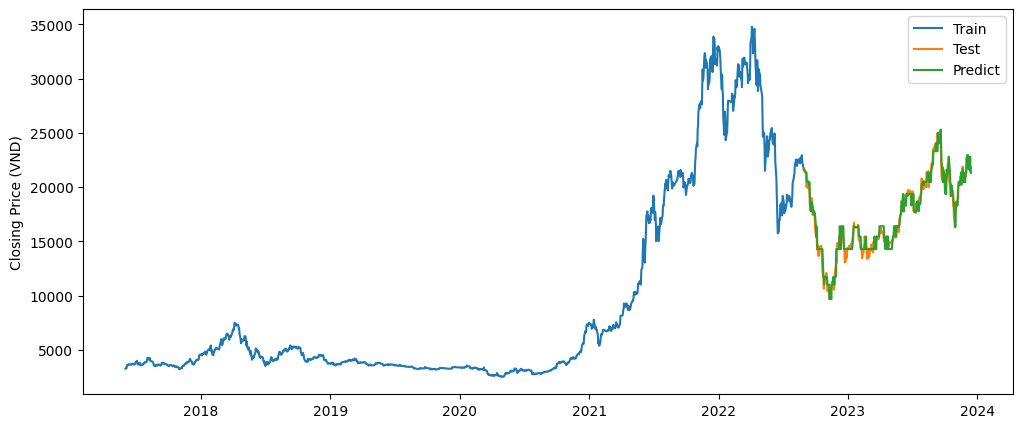

In [12]:
#vẽ mô hình
plt.figure(figsize=(12, 5))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred, label='Predict')
plt.ylabel('Closing Price (VND)')
plt.legend()
plt.show()

In [13]:
# lấy giá trị Close của ngày cuối cùng trong dataset
last_row = VND.tail(1)
last_data = last_row['Close'].values.reshape(-1,1)
last_data

array([[21450]])

In [14]:
# tạo mảng chứa giá trị predict của 60 ngày tiếp theo
x_next_60_days = []

# predict giá Close 60 ngày tiếp theo dựa vào giá Close của ngày trước đó
for i in range(60):
    x_pred_next = model.predict(last_data)
    x_next_60_days.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)
print("Kết quả dự đoán :", x_next_60_days)


Kết quả dự đoán : [array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), array([21308.328], dtype=float32), a

In [15]:
x_next_60_days = np.array(x_next_60_days)
x_next_60_days.reshape(-1,1)

array([[21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],
       [21308.328],


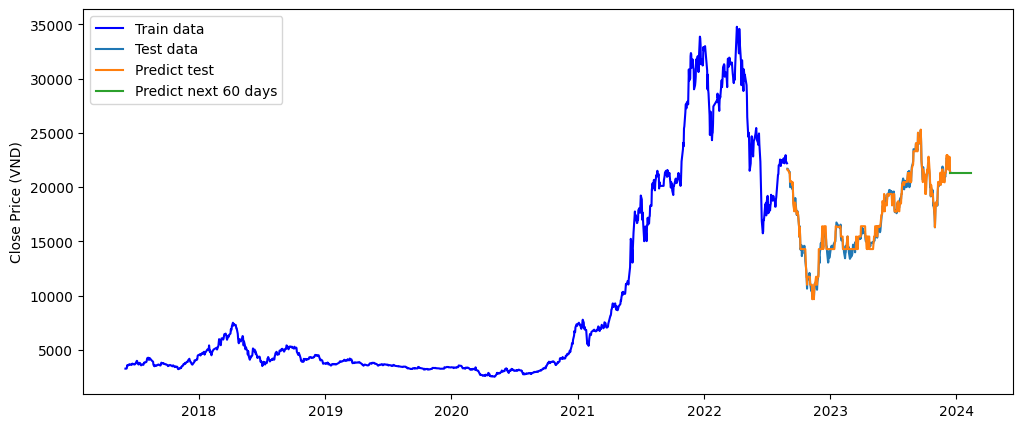

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(X_train, label='Train data', color = 'b')
plt.plot(X_test, label='Test data')
plt.plot(X_test.index, y_pred, label='Predict test')


last_date = X_test.index[-1]
next_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')
plt.plot(next_dates, x_next_60_days, label='Predict next 60 days')

plt.ylabel('Close Price (VND)')
plt.legend(loc = 'upper left')
plt.show()
